# Video Actor Synchroncy and Causality (VASC)
## RAEng: Measuring Responsive Caregiving Project
### Caspar Addyman, 2020
### https://github.com/infantlab/VASC

# Step 3: Analyse the data using scipy statsmodels

This script correlates and compares the timeseries of wireframes for the two figures in the video `["parent", "infant"]`

We start by reloading the saved parquet file containing the multi-index numpy array of all [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) data from all pairs of individuals. 



In [1]:
import sys
import os
import json
import math
import numpy as np       
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
%matplotlib inline

import logging
import ipywidgets as widgets  #let's us add buttons and sliders to this page.
from ipycanvas import Canvas

import vasc #a module of our own functions (found in vasc.py in this folder)

#turn on debugging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%pdb on

Automatic pdb calling has been turned ON


In [2]:
jupwd =  os.getcwd() + "\\"
projectpath = os.getcwd() + "\\..\\SpeakNSign\\"
# projectpath = os.getcwd() + "\\..\\lookit\\"

# locations of videos and output
videos_in = projectpath 
videos_out   = projectpath + "out"
#videos_out = "E:\\SpeakNSign\\out"
videos_out_openpose   = videos_out + "\\openpose"
videos_out_timeseries = videos_out + "\\timeseries"
videos_out_analyses   = videos_out + "\\analyses"

### 3.1 Load the clean data as a DataFrame

Reload the clean data file created in step 2. 

In [3]:
#retrieve the list of base names of processed videos.
try:
    with open(videos_out + '\\clean.json') as json_file:
        videos = json.load(json_file)
        print("Existing clean.json found..")
except:
    print("File clean.json not found.")

Existing clean.json found..


In [4]:
print('reading parquet file:')
df = pq.read_table(videos_out_timeseries + '\\cleandata.parquet').to_pandas()

#sort the column names as this helps with indexing
df = df.sort_index(axis = 1)
print(df.head())

reading parquet file:
video     SS003                                                          \
person   infant                                                           
coord        0        1         2        3        4         5        6    
0       556.540  356.132  0.899432  555.002  395.181  0.469440  547.184   
1       555.026  356.080  0.761866  556.577  390.507  0.352666  545.625   
2         0.000    0.000  0.000000    0.000    0.000  0.000000    0.000   
3       556.507  354.526  0.722555  553.467  395.316  0.331564  556.561   
4         0.000    0.000  0.000000    0.000    0.000  0.000000    0.000   

video                               ...  SS098                                \
person                              ... parent                                 
coord        7         8        9   ...     65   66   67   68   69   70   71   
0       382.758  0.336208  515.839  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       379.606  0.275334  531.538  ...    0.0  0.0  0.0 

## 3.2 Process the data 

Next we set all 0 values to as missing value `np.nan` to enable interpolation.
Then use numpy's built in `interpolate` method. 

In [5]:
df = df.replace(0.0, np.nan)

#are we going to use all the data or a subset?
first = 501
last = 8500

df = df.truncate(before  = first, after = last)

In [6]:
df = df.interpolate()

In [7]:
#take a quick look
print(df.head())
df.shape

video     SS003                                                          \
person   infant                                                           
coord        0        1         2        3        4         5        6    
501     559.714  357.592  0.787151  555.025  396.784  0.356000  555.002   
502     559.765  357.602  0.839487  556.574  398.406  0.373636  559.706   
503     559.783  357.606  0.777033  556.540  396.856  0.284398  558.187   
504     559.736  357.585  0.785370  556.574  398.360  0.346349  558.166   
505     559.691  357.645  0.834648  556.556  396.822  0.363410  558.152   

video                                  ...  SS098                              \
person                                 ... parent                               
coord        7         8           9   ...     65  66  67  68  69  70  71  72   
501     393.608  0.236688  512.724000  ...    NaN NaN NaN NaN NaN NaN NaN NaN   
502     395.207  0.250447  513.843571  ...    NaN NaN NaN NaN NaN NaN NaN N

(8000, 7800)

### 3.2.1 Mean movements
We create a dictionary of the subsets of OpenPose coordinates we want to average and then call `mean` on the Pandas dataframe. e.g.

```
meanpoints = {
               "headx" : [0, 3, 45, 48, 51, 54],
               "heady" : [1, 4, 46, 49, 52, 55],
               "allx" :  [0, 3, 6, 9, ...],
               "ally" :  [1, 4, 7, 10, ...]
             }
```

Then we call the `vasc.averageCoordinateTimeSeries` function to average across sets of coordinates. For a given set of videos and people. For example

In:
```
videos = "All"
people = "Both"
df2 = vasc.averageCoordinateTimeSeries(df,meanpoints,videos,people)
df2.head
```

Out:
```
person      infant                                          parent   
avgs         headx       heady          xs          ys       headx   
501     565.996600  369.840600  534.895615  398.482538  471.686200   
502     567.231800  369.887600  534.354198  398.706552  471.849400   
503     567.228600  370.159600  534.444328  398.678133  471.711600   
504     566.912600  369.857000  535.369536  398.551636  472.309400
...            ...         ...         ...         ...         ...
```


In [8]:
meanpoints = {"head" : vasc.headxys,
              "headx": vasc.headx,
              "heady": vasc.heady,
              "arms" : vasc.armsxys,
              "armsx": vasc.armsx,
              "armsy": vasc.armsy,
              "all"  : vasc.xys,
              "allx" : vasc.xs,
              "ally" : vasc.ys}

vids = "All"
people = ["infant","parent"]

#average across the points in each group (all points of head etc. )
avgdf = vasc.averageCoordinateTimeSeries(df,meanpoints,vids,people)

In [9]:
avgdf.head

<bound method NDFrame.head of video        SS003                                                  \
person      infant                                                   
avgs          head       headx       heady        arms       armsx   
501     467.918600  565.996600  369.840600  464.463600  526.178200   
502     468.559700  567.231800  369.887600  463.025586  523.287914   
503     468.694100  567.228600  370.159600  462.667971  523.204629   
504     468.384800  566.912600  369.857000  463.712157  525.605343   
505     468.539600  566.901600  370.177600  462.892543  523.339857   
...            ...         ...         ...         ...         ...   
8496    441.726583  527.623667  355.829500  437.275333  477.756333   
8497    441.721500  525.792500  357.650500  438.857583  481.399167   
8498    441.845083  526.313833  357.376333  436.504500  476.445833   
8499    441.857000  526.825833  356.888167  437.139500  477.223667   
8500    441.591833  525.014500  358.169167  439.633583  483.

### 3.2.2 Rolling window of movements

One thing we'd like to know is if mothers move in response to infants. The raw time series are probably too noisy to tell us this so instead we can look at few alternatives

1. **Smoothed** - if we average the signal over a short rolling window we smooth out any high-frequency jitter. 
2. **Variance** - the variance of movement over a short rolling window. First we apply 2 second long (50 frame) rolling window to each coordinate of the body and use the stddev or variance function `std()` or `var()` . Then we take averages as in the step above. However, this time we combine x and y coordinates as this is now a movement index.




In [10]:
win = 50 #2 seconds
halfwin = math.floor(win/2)

smoothdf = df.rolling(window = 5).mean()
smoothdf = smoothdf.truncate(before  = first, after = last)

vardf = df.rolling(window = win, min_periods = halfwin).var()
vardf = vardf.truncate(before  = first + 50, after = last) # cut out the empty bits at the start
 
smoothdf = vasc.averageCoordinateTimeSeries(smoothdf,meanpoints,vids,people)
vardf = vasc.averageCoordinateTimeSeries(vardf,meanpoints,vids,people)

Let's create a widget to plot some graphs of the data

In [32]:
vidlist = [] #used to fill dropdown options
for vid in videos:  
    vidlist.append(vid)
        
pickvid = widgets.Dropdown(
    options= vidlist,
    value= vidlist[0],
    description='Subject:'
)

features = []
for f in meanpoints:
    features.append(f)
    
pickfeature = widgets.Dropdown(
    options= features,
    value= features[0],
    description='Feature:'
)

linetypes = ["Mean point", "Smoothed Mean (5 frames)","Variance over 2 secs"]
picktype = widgets.Dropdown(
    options= linetypes,
    value= linetypes[0],
    description='Line type:'
)

def pickvid_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)
        
def pickfeature_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)

def picktype_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)
        
pickvid.observe(pickvid_change, 'value') 
pickfeature.observe(pickfeature_change, 'value') 
picktype.observe(picktype_change, 'value') 
button_update = widgets.Button(description="Redraw")
output = widgets.Output()


def drawGraphs(vid, feature, linetype):
    """Plot input signals"""
    plt.ion()

    f,ax=plt.subplots(4,1,figsize=(14,10),sharex=True)
    ax[0].set_title('Infant')
    ax[1].set_title('Parent')
    ax[1].set_xlabel('Frames')

    who = ["infant","parent"]

    if linetype == linetypes[0]:
        usedf = avgdf
    elif linetype == linetypes[1]:
        usedf = smoothdf
    else:
        usedf = vardf
        
    #to select a single column..
    infant = usedf[(vid, people[0], feature)].to_frame()
    parent = usedf[(vid, people[1], feature)].to_frame()
    n  = np.arange(usedf.shape[0])
    
    #selecting multiple columns slightly messier
    #infant = df3.loc[50:,(vid, part[0], ('head','arms', 'all'))]
    #parent = df3.loc[50:,(vid, part[1], ('head','arms', 'all'))]

    ax[0].plot(n,infant)
    ax[1].plot(n,parent, color='b')
    
    #calculate the correlations in a shorter rolling window
    r_window_size = 120
    rolling_r = usedf[(vid, who[0], feature)].rolling(window=r_window_size, center=True).corr(vardf[(vid, who[1], feature)])


    usedf.loc[:,(vid, slice(None), feature)].plot(ax=ax[2])
    ax[2].set(xlabel='Frame',ylabel='Movement index for parent and infant')

    rolling_r.plot(ax=ax[3])
    ax[3].set(xlabel='Frame',ylabel='Pearson r')
    ax[3].set_title("Local correlation with rolling window size " + str(r_window_size))

    plt.show() 

def updateAll(forceUpdate = False):
    output.clear_output(wait = True)
    if forceUpdate:
        logging.debug('forceUpdate')
        #slider.value = 0
        #slider.max = videos[pickvid.value][pickcam.value]["end"]
    with output:
        display(pickvid,pickfeature,picktype,button_update)  
        drawGraphs(pickvid.value,pickfeature.value,picktype.value)
    
#draw everything for first time
updateAll(True)
output

Output()

### 3.3 Movement analysis

First we run some simple correlations between the mother and infant.

In [12]:
infant = vardf[(vid, people[0], 'head')].to_frame()
infant.head
print(type(infant))

<class 'pandas.core.frame.DataFrame'>


In [13]:
vid = "SS003"
vardf[(vid, people[0], 'head')].corr(vardf[(vid, people[1], 'head')]) 

0.1577043484821421

In [14]:
who = ["infant","parent"]
parts = ["head","arms","all"]
results = pd.DataFrame(columns = ("corrHead","lagHead","corrArms","lagArms","corrAll","lagAll","DyadSynScore"),
                      index = videos)

In [15]:
#loop through colculate for each pair
for vid in videos:
    thisrow = []
    for part in parts:
        #to select a single column..
        pearson = vardf[(vid, people[0], part)].corr(vardf[(vid, people[1], part)])
 
        thisrow.append(pearson) #this is for correlation
        thisrow.append(None) #this is for maximum lag
    
    thisrow.append(None) #don't have DyadSynScore yet 
    results.loc[vid] = thisrow

In [ ]:
#take a quick look
results

## 3.4 Comparing to human coding. 

We have a spreadsheet of syhnchrony scores for each parent infant dyad. Here we see if we can find a measure that correlates with the human scores.

First, load up the spreadsheet..

In [16]:
excelpath = projectpath + "\\SS_CARE.xlsx"

filename, file_format = os.path.splitext(excelpath)
if file_format and file_format == 'xls':
    # use default reader 
    videolist = pd.read_excel(excelpath)
else: 
    #since dec 2020 read_excel no longer supports xlsx (!?) so need to use openpyxl like so..
    videolist = pd.read_excel(excelpath, engine = "openpyxl")
    
videolist = videolist.set_index("subject")

In [ ]:
#take a quick look
videolist

In [17]:
#copy the dyad syncrhony and maternal sensitivity scores into our data frame.
results["DyadSynScore"] = videolist["DyadSyn"]
results["MatSensScore"] = videolist["MatSens"]

In [ ]:
#take a quick look
results

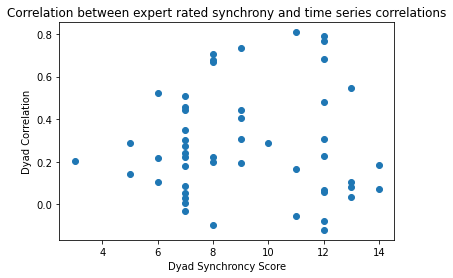

In [20]:
#scatter plots of these results. 
plt.scatter(results["DyadSynScore"],results["corrArms"], )
plt.title("Correlation between expert rated synchrony and time series correlations")
plt.xlabel("Dyad Synchroncy Score")
plt.ylabel("Dyad Correlation")
plt.show()

In [24]:
rolling_r.mean()

0.18970482618748924

So 

<ipython-input-26-518f111a6da2>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);


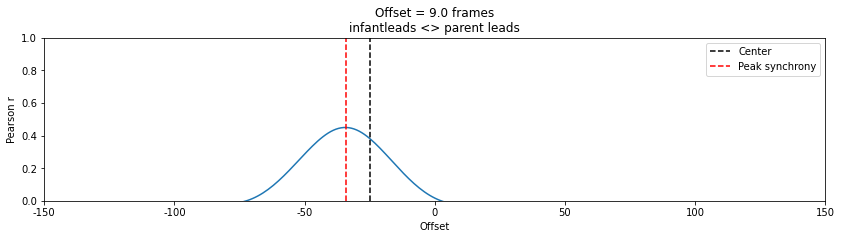

In [26]:


d1 = vardf[(vid, who[0], parts[0])]
d2 = vardf[(vid, who[1], parts[0])]
seconds = 5
fps = 25
wholeads = who[0] + 'leads <> ' + who[1] + ' leads'
rs = [vasc.crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\n' + wholeads,ylim=[.0,1],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);
plt.legend()

## 3.4 Granger Causality

The next thing to look at is if the movements of the infant predict the movements of the parent. This would suggest parent is responding to the infant. 


In [ ]:

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

https://www.machinelearningplus.com/time-series/time-series-analysis-python/
    
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
    